<a href="https://colab.research.google.com/github/AndreaWalrus/Esercitazione8-23-24/blob/main/QuickDrawCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Esercizio Quick Draw

In [1]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, SubsetRandomSampler, ConcatDataset, Dataset, Subset, random_split, IterableDataset
from torchvision import datasets
from torchvision.transforms import v2
from torchvision.models import resnet50, ResNet50_Weights
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import pandas as pd
import itertools

# Import tensorboard logger from PyTorch
from torch.utils.tensorboard import SummaryWriter

# This is when we use GPU instance to run colab.
# How to change Runtime in colab??
# Go to Runtime-> Change Runtime type -> Hardware Accelerator -> GPU

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', device)
torch.manual_seed(42)
torch.multiprocessing.set_sharing_strategy('file_system')

Using PyTorch version: 2.6.0+cu124  Device: cuda


In [2]:
import struct
import os, re, random

def unpack_drawing(fh):
    # Read one drawing record from the binary file handle
    key_id,       = struct.unpack('Q',  fh.read(8))
    country_code, = struct.unpack('2s', fh.read(2))
    recognized,   = struct.unpack('b',  fh.read(1))
    timestamp,    = struct.unpack('I',  fh.read(4))
    n_strokes,    = struct.unpack('H',  fh.read(2))

    strokes = []
    for _ in range(n_strokes):
        n_pts, = struct.unpack('H', fh.read(2))
        fmt    = f'{n_pts}B'
        x_pts  = struct.unpack(fmt, fh.read(n_pts))
        y_pts  = struct.unpack(fmt, fh.read(n_pts))
        strokes.append((x_pts, y_pts))

    return {
        'key_id':      key_id,
        'country':     country_code.decode('ascii'),
        'recognized':  bool(recognized),
        'timestamp':   timestamp,
        'strokes':     strokes
    }

def strokes_to_image(raw_strokes, size=256, line_width=1):
    """
    raw_strokes: list of strokes, each ([x0,x1,...], [y0,y1,...])
                 where each x_i, y_i is already in [0..255] integer
    size:       canvas size (should be 256)
    line_width: thickness of the drawn line (in pixels)
    """
    # White canvas
    img = Image.new("L", (size, size), color=255)
    draw = ImageDraw.Draw(img)

    # Draw each stroke without any rescaling
    for x_pts, y_pts in raw_strokes:
        # Make sure points are (x,y) tuples of ints
        points = list(zip(map(int, x_pts), map(int, y_pts)))
        if len(points) >= 2:
            draw.line(points, fill=0, width=line_width)

    # Return as NumPy array
    return np.array(img, dtype=np.uint8)

def load_quickdraw_bin(filename, n_samples=None):
    images = []
    with open(filename, 'rb') as fh:
        for i in range(n_samples):
            try:
                rec = unpack_drawing(fh)
            except struct.error:
                break
            # Render strokes in 256×256 and add to list
            img = strokes_to_image(rec['strokes'], size=256, line_width=1)
            images.append(img)
            if i%1000 == 0:
              print('Progress: '+str(int(100*i/n_samples))+'%')

    arr = np.stack(images, axis=0)
    arr = arr[:, np.newaxis, :, :].astype(np.uint8)
    return arr

def parseQuickDraw(dir, n_samples):
  imgs_array = None
  labels_array = None
  i=0
  names = []
  for f in os.listdir(dir):
    x = re.search(r"(.+)\.bin", f)
    name = str(x.group(1))
    names.append(name)
    print('Loading: '+dir+name+'.bin')

    # Load all images for each file in imgs and triplicate the channel layer
    imgs = load_quickdraw_bin(dir+name+'.bin', n_samples=n_samples)
    imgs = np.repeat(imgs, 3, axis=1)

    # Initialize the label_array and fill it up to n_samples with the file name
    labels = [name]
    labels = np.reshape(labels, (1, 1))
    labels = np.repeat(labels, n_samples, axis=0)


    if i==0:
      imgs_array = imgs
      labels_array = labels
    else:
      imgs_array = np.concatenate((imgs_array, imgs), axis=0)
      labels_array = np.concatenate((labels_array, labels), axis=0)

    i+=1
    print('Loaded: '+dir+name+'.bin\n')

    '''
    # Save both arrays as .npz for easy of access
    with open(dir+'../npy/'+name+'.npz', 'wb') as f:
      np.savez(f, label=labels, img=imgs)
      print('Saved: '+dir+'../npy/'+name+'.npz\n')
    '''
  print(imgs_array.shape)
  print(labels_array.shape)
  print('Finished')
  return imgs_array, labels_array, names

In [3]:
class QuickDrawShuffledStream(IterableDataset):
    def __init__(self, bin_dir, classes, n_per_class=None, transform=None):
        """
        Streams sketches by randomly choosing among class streams.
        """
        self.bin_dir     = bin_dir
        self.classes     = list(classes)
        self.n_per_class = n_per_class
        self.transform   = transform
        self.class_to_idx= {c:i for i,c in enumerate(self.classes)}

    def __iter__(self):
        # Open a file handle & counter for each class
        handles = {}
        counts  = {}
        for c in self.classes:
            path = os.path.join(self.bin_dir, f"{c}.bin")
            handles[c] = open(path, 'rb')
            counts[c]  = 0

        alive = set(self.classes)
        try:
            while alive:
                # Pick a random class that still has data
                cls = random.choice(list(alive))
                fh  = handles[cls]

                # Stop if we've hit the per‑class limit
                if self.n_per_class and counts[cls] >= self.n_per_class:
                    alive.remove(cls)
                    continue

                # Try to unpack one drawing
                try:
                    rec = unpack_drawing(fh)
                except struct.error:
                    alive.remove(cls)
                    continue

                # Render & tensorize
                arr = strokes_to_image(rec['strokes'], size=256, line_width=1)
                img = torch.from_numpy(arr).unsqueeze(0).float().div(255.0)
                img = img.repeat(3, 1, 1) # Repeat the single channel 3 times
                if self.transform:
                    img = self.transform(img)

                label = self.class_to_idx[cls]
                counts[cls] += 1
                yield img, label
        finally:
            for fh in handles.values():
                fh.close()

    def __len__(self):
        return self.n_per_class * len(self.classes)

    def num_classes(self):
        return len(self.classes)

class SliceDataset(IterableDataset):
    def __init__(self, source_ds, start, end):
        """
        source_ds: the original IterableDataset
        start:     first index to include (inclusive)
        end:       first index to *exclude* (exclusive)
        """
        self.source = source_ds
        self.start  = start
        self.end    = end

    def __iter__(self):
        # islice will skip up to start, then yield up to end
        return itertools.islice(self.source.__iter__(), self.start, self.end)

    def __len__(self):
        return self.end - self.start

In [4]:
classes = []
for f in os.listdir("datasets/QuickDraw/binary60/"):
    x = re.search(r"(.+)\.bin", f)
    name = str(x.group(1))
    classes.append(name)
print(classes)

['airplane', 'alarm clock', 'ant', 'anvil', 'axe', 'banana', 'bat', 'binoculars', 'bowtie', 'broom', 'bucket', 'cactus', 'camel', 'candle', 'castle', 'cat', 'cello', 'chair', 'compass', 'cookie', 'cow', 'dog', 'donut', 'dragon', 'elephant', 'eyeglasses', 'face', 'fan', 'fire hydrant', 'giraffe', 'headphones', 'helicopter', 'horse', 'hourglass', 'ice cream', 'key', 'knife', 'laptop', 'microphone', 'moon', 'motorbike', 'onion', 'paper clip', 'pear', 'piano', 'pillow', 'pizza', 'pond', 'pool', 'potato', 'scissors', 'submarine', 'swan', 't-shirt', 'teddy-bear', 'tornado', 'train', 'umbrella', 'violin', 'windmill']


In [5]:
weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)
preprocess = weights.transforms()

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:22<00:00, 4.64MB/s]


In [6]:
dataset = QuickDrawShuffledStream(
    bin_dir="datasets/QuickDraw/binary60/",
    classes=classes,
    n_per_class=1500,
    transform=preprocess
)
loader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=4)
print(len(dataset))

90000


In [7]:
n = len(dataset)
n_train = int(0.8 * n)
n_val   = int(0.1 * n)
n_test  = n - n_train - n_val

train_ds = SliceDataset(dataset,      0,            n_train)
val_ds   = SliceDataset(dataset,      n_train,    n_train+n_val)
test_ds  = SliceDataset(dataset,      n_train+n_val, n)
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

train_loader = DataLoader(train_ds, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=64, shuffle=False, num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

72000
9000
9000


In [8]:
in_feats = model.fc.in_features
model.fc = torch.nn.Linear(in_feats, dataset.num_classes())
model = model.to(device)

torch.Size([64, 3, 224, 224])
torch.Size([64])


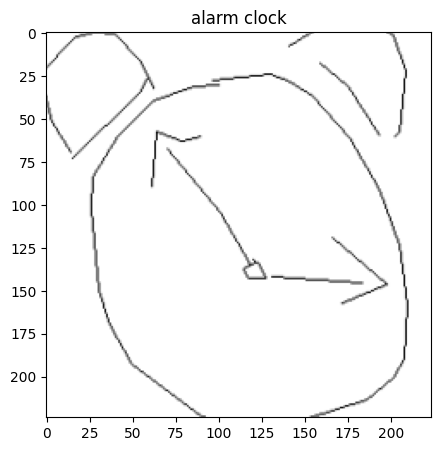

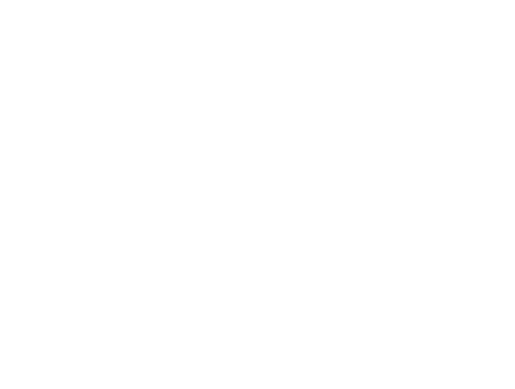

In [11]:
# Sample the dataset
imgs, labels = next(iter(train_loader))
print(imgs.shape)
print(labels.shape)

plt.figure(figsize=(5,5))
plt.title(classes[int(labels[0])])
plt.imshow(imgs[0][0], cmap="gray")
plt.show()
plt.axis('off')
plt.grid(visible=False)
plt.show()

In [12]:
num_classes = len(classes)
in_feats    = model.fc.in_features
model.fc    = nn.Linear(in_feats, num_classes).to(device)

for name, param in model.named_parameters():
    if name.startswith('fc.'):
        param.requires_grad = True
    else:
        param.requires_grad = False


In [13]:
# Reset FC layer parameters
model.fc.reset_parameters()

In [14]:
optimizer = torch.optim.AdamW(model.fc.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

In [15]:
# Check if model is running on GPU
print("Using device:", device)
print("Model on:", next(model.parameters()).device)

Using device: cuda
Model on: cuda:0


In [16]:
# Training loop
%%time

epochs = 5
writer = SummaryWriter('logs/QuickDraw')
imgs = imgs.to(device)
writer.add_graph(model, imgs)
for epoch in range(epochs):

    # Train
    model.train()
    train_loss, correct = 0., 0.
    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(train_loader):
        # Copy data to GPU if needed
        data = data.to(device)
        target = target.to(device)

        # Zero gradient buffers
        optimizer.zero_grad()

        # Pass data through the network
        preds = model(data)
        #preds = preds.squeeze(dim=1)

        # Calculate loss
        loss = criterion(preds, target)

        # Backpropagate
        loss.backward()

        # Update weights
        optimizer.step()


        correct += (preds.argmax(1) == target).sum().item()
        train_loss+=loss.data.item()*data.size(0)

        if batch_idx % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

    train_acc = 100*correct/len(train_loader.dataset)
    train_loss/=len(train_loader.dataset)

    # Validate
    model.eval()
    val_loss, correct = 0, 0

    with torch.no_grad():
      for data, target in val_loader:
        data = data.to(device)
        target = target.to(device)

        preds = model(data)

        val_loss += criterion(preds, target).data.item()*data.size(0)
        correct += (preds.argmax(1) == target).sum().item()

      val_acc = 100*correct/len(val_loader.dataset)
      val_loss/=len(val_loader.dataset)

    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(val_loader.dataset), val_acc))

    writer.add_scalars('Loss', {'Training':train_loss, 'Validation':val_loss}, global_step=epoch)
    writer.add_scalars('Accuracy', {'Training':train_acc, 'Validation':val_acc}, global_step=epoch)
writer.close()


Train Epoch: 0 [0/72000 (0%)]	Loss: 4.083675
Train Epoch: 0 [12800/72000 (18%)]	Loss: 2.457772
Train Epoch: 0 [25600/72000 (36%)]	Loss: 1.807346
Train Epoch: 0 [38400/72000 (53%)]	Loss: 1.288244
Train Epoch: 0 [51200/72000 (71%)]	Loss: 1.377170
Train Epoch: 0 [64000/72000 (89%)]	Loss: 1.616203
Train Epoch: 0 [76800/72000 (107%)]	Loss: 1.416900
Train Epoch: 0 [89600/72000 (124%)]	Loss: 1.500979
Train Epoch: 0 [102400/72000 (142%)]	Loss: 1.429412
Train Epoch: 0 [115200/72000 (160%)]	Loss: 1.532958
Train Epoch: 0 [128000/72000 (178%)]	Loss: 1.577047
Train Epoch: 0 [140800/72000 (196%)]	Loss: 1.430372
Train Epoch: 0 [153600/72000 (213%)]	Loss: 1.159450
Train Epoch: 0 [166400/72000 (231%)]	Loss: 1.362100
Train Epoch: 0 [179200/72000 (249%)]	Loss: 1.153047


KeyboardInterrupt: 